# Convolutional Autoencoder for Minimization in Image Data Compression Loss

This model will be the high-level feature extractor for images which will be further sent into CDCGAN as the condition feature for image inpainting and restoration.

In [16]:
import numpy as np
import argparse
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
from random import randint
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow.contrib.slim as slim
import scipy.misc
import scipy

## Import MNIST Dataset

The dataset composes three elements:

mnist.train.images of shape 5.5k * 28 * 28

mnist.train.labels of shape 5.5k 

mnist.train.validationn shape 5k * 28 * 28

In [19]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 28, 28)
(55000,)


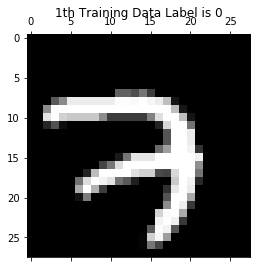

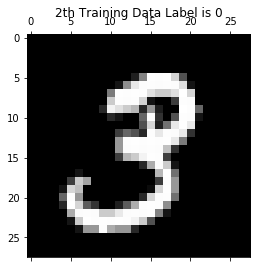

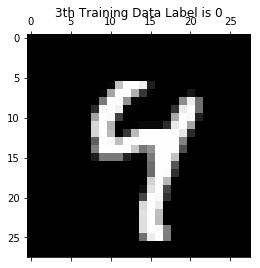

In [20]:
#print out several data in mnist
trainimg = mnist.train.images
train_y = mnist.train.labels
nsample = 1
randidx = np.random.randint(trainimg.shape[0], size=nsample)

train_x = np.reshape(trainimg,(trainimg.shape[0],28,28))
print(train_x.shape)
print(train_y.shape)

for i in [0, 1, 2]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    curr_label = np.argmax(train_y[i] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))

In [21]:
#Define Globals
NUM_LABELS = 47
rnd = np.random.RandomState(123)
tf.set_random_seed(123)
batch_size = 128

In [22]:
#define utils

def convert_image_data_to_float(image_raw):
    img_float = tf.expand_dims(tf.cast(image_raw, tf.float32) / 255, axis=-1)
    return img_float


def visualize_ae(i, x, features, reconstructed_image):
    '''
    This might be helpful for visualizing your autoencoder outputs
    :param i: index
    :param x: original data
    :param features: feature maps
    :param reconstructed_image: autoencoder output
    :return:
    '''
    plt.figure(0)
    plt.imshow(x[i, :, :], cmap="gray")
    plt.savefig("./plts/origin/{}.jpg".format(i))
    plt.figure(1)
    plt.imshow(reconstructed_image[i, :, :, 0], cmap="gray")
    plt.savefig("./plts/reconstructed/{}.jpg".format(i))
    plt.figure(2)
    plt.imshow(np.reshape(features[i, :, :, :], (4, -1), order="F"), cmap="gray")
    plt.savefig("./plts/fmap/{}.jpg".format(i))



## Define Necessary Layers

In [23]:
#useful layers 

def conv2d(input, name, kshape, strides=[1, 1, 1, 1], actv_fn = "RELU"):
    with tf.name_scope(name):
        W = tf.get_variable(name='w_'+name,
                            shape=kshape,
                            initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        b = tf.get_variable(name='b_' + name,
                            shape=[kshape[3]],
                            initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        out = tf.nn.conv2d(input,W,strides=strides, padding='SAME')
        out = tf.nn.bias_add(out, b)
        if actv_fn == "RELU":
            out = tf.nn.relu(out)
        elif actv_fn == 'SIGMOID':
            out = tf.nn.sigmoid(out)
        else:
            print("No such activation function implemented!")
            exit(0)

        return out
# ---------------------------------
def deconv2d(input, name, kshape, n_outputs, strides=[1, 1] ,actv_fn = "RELU"):

    with tf.name_scope(name):
        if actv_fn == "RELU":
            out = tf.contrib.layers.conv2d_transpose(input,
                                                 num_outputs= n_outputs,
                                                 kernel_size=kshape,
                                                 stride=strides,
                                                 padding='SAME',
                                                 weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                                                 biases_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                                 activation_fn=tf.nn.relu)
        elif actv_fn == 'SIGMOID':
            out = tf.contrib.layers.conv2d_transpose(input,
                                                 num_outputs= n_outputs,
                                                 kernel_size=kshape,
                                                 stride=strides,
                                                 padding='SAME',
                                                 weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                                                 biases_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                                 activation_fn=tf.nn.sigmoid)
        else:
            print("No such activation funciton implemented!")
            exit(0)

        return out
#   ---------------------------------
def maxpool2d(x,name,kshape=[1, 2, 2, 1], strides=[1, 2, 2, 1]):
    with tf.name_scope(name):
        out = tf.nn.max_pool(x,
                             ksize=kshape, #size of window
                             strides=strides,
                             padding='SAME')
        return out
#   ---------------------------------
def upsample(input, name, factor=[2,2]):
    size = [int(input.shape[1] * factor[0]), int(input.shape[2] * factor[1])]
    with tf.name_scope(name):
        out = tf.image.resize_nearest_neighbor(input, size=size, align_corners=False, name=None)
        return out
#   ----------------------------------
def fullyConnected(input, name, output_size, actv_fn = "RELU"):
    with tf.name_scope(name):
        input_size = input.shape[1:]
        input_size = int(np.prod(input_size))
        W = tf.get_variable(name='w_'+name,
                            shape=[input_size, output_size],
                            initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        b = tf.get_variable(name='b_'+name,
                            shape=[output_size],
                            initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        input = tf.reshape(input, [-1, input_size])
        if actv_fn == "RELU":
            out = tf.nn.relu(tf.add(tf.matmul(input, W), b))
        elif actv_fn == "SOFTMAX":
            out = tf.nn.softmax(tf.add(tf.matmul(input, W), b))
        else:
            print("Activation function not implemented!!")
            exit(0)
        return out

## Model Description

see [] for illustration

In [24]:
#Define model structures
def CAE_encoder(x, name):

    #print(x.shape)
    c1 = conv2d(x, name="c1", kshape =[3,3,1,32] )
    #print(c1.shape)
    p1 = maxpool2d(c1, name = "p1")
    #print(p1.shape)
    c2 = conv2d(p1, name = "c2", kshape =[3,3,32,64],strides = [1,2,2,1])
    #print(c2.shape)
    c3 = conv2d(c2, name = "c3", kshape =[3,3,64,64])
    #print(c3.shape)
    out = maxpool2d(c3, name = "out")
    #print(out.shape)
    return out

def CAE_decoder(x, name):  

    #print(x.shape)
    #up3 = upsample(x, name = "up3")
    up3 = tf.image.resize_nearest_neighbor(x, size=[7,7], align_corners=False, name=None)
    #print(up3.shape)
    dc3 = deconv2d(up3,name = "dc3", kshape = [3,3], n_outputs = 64)
    #print(dc3.shape)
    dc2 = deconv2d(dc3,name = "dc2", kshape = [3,3], n_outputs = 32,  strides = [2,2])
    #print(dc2.shape)
    up2 = upsample(dc2,name = "up2")
    #print(up2.shape)
    dc1 = deconv2d(up2,name = "dc1", kshape = [3,3], n_outputs = 1, actv_fn = "SIGMOID")
    #print(dc1.shape)
    return dc1

In [25]:
#training functions
def train_cnn(x, y, placeholder_x, placeholder_y):
    hs = [512,1024]
    optimizers = ["SGD","ADAM"]
    lrs = [0.1,0.01,0.001]
    ps = [0.5,1]
    placeholder_xf = convert_image_data_to_float(placeholder_x)
    encoder_output = CAE_encoder(placeholder_xf, "Encoder")

    for p in ps: 
        
        train_X = x[:int(x.shape[0]*p)]
        train_Y = y[:int(y.shape[0]*p)]
        val_X = x[int(x.shape[0]*p):]
        val_Y = y[int(y.shape[0]*p):]
        if p == 1: ##calculate accuracy on the whole training dataset when p = 1
            val_X = train_X
            val_Y = train_Y

        n_epochs = 200
        best_loss = 999 
        best_lr = 0
        best_opt = None
        best_h = 0


        for opt in optimizers:
            for lr in lrs:
                for h in hs:
                    fc1 = fullyConnected(encoder_output, "fc1_{}_{}_{}_{}".format(p,opt,lr,h), h)
                    out = fullyConnected(fc1, "fc2_{}_{}_{}_{}".format(p,opt,lr,h), 47, "SOFTMAX")
                    
                    #loss = tf.nn.softmax_cross_entropy_with_logits( logits=out , labels = placeholder_y)
                    
                    loss = tf.losses.sparse_softmax_cross_entropy(labels=placeholder_y, logits=out)
                    #preds = tf.argmax(out, axis = 1)
                    #accu = tf.reduce_mean(tf.equal(placeholder_y,preds))
                    #accu, accu_op = tf.metrics.accuracy(labels = placeholder_y,predictions = preds)
                    accu = tf.reduce_mean( tf.cast(tf.equal( placeholder_y, tf.cast( tf.argmax(out,1), tf.int32 ) ), tf.float32))      
                    optimizer = None
                    if opt == "SGD":
                        optimizer = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(loss)
                    else:
                        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)


                    saver = tf.train.Saver()
                    
                    
                    with tf.Session() as sess:
                        sess.run(tf.global_variables_initializer())
                        sess.run(tf.local_variables_initializer())
                        for epoch in range(n_epochs):
                            avg_loss = 0
                            n_batches = int( int(train_X.shape[0]) / batch_size )
                            # Loop over all batches
                            a = None
                            for i in range(n_batches):
                                batch_x = train_X[i*batch_size:(i+1)*batch_size]
                                batch_y = train_Y[i*batch_size:(i+1)*batch_size]
                                # Run optimization op (backprop) and cost op (to get loss value)
                                _, l, a = sess.run([optimizer, loss, accu], feed_dict={placeholder_x: batch_x, placeholder_y :batch_y})
                                # Compute average loss
                                avg_loss += l / n_batches
                            # Display logs per epoch step
                            
                            print('Epoch', epoch+1, ' / ', n_epochs, 'loss:', avg_loss, 'accu:', a)
                            save_path = saver.save(sess, "./cnn_model/{}/x-val_{}_{}_{}/model.ckpt".format(p,opt,lr,h))       
                        #evaluate on valset
                        l = loss.eval(feed_dict = {placeholder_x: val_X, placeholder_y : val_Y})
                        a = sess.run(accu,feed_dict = {placeholder_x: val_X, placeholder_y : val_Y})
                        print("Validation loss: {}, Validation accu: {}".format(l,a))
                        if l < best_loss:
                            best_loss = l
                            best_lr = lr
                            best_opt = opt
                            best_h = h
                            
        #move the best model under ./ae_model
        print("The best hyperparameters through holdout validation: p = {} lr = {} H = {} OPT = {}".format(p, best_lr,best_h,best_opt))
        shutil.copytree("./cnn_model/{}/x-val_{}_{}_{}".format(p,best_opt,best_lr,best_h), "./cnn_model/{}/best".format(p))
        f = open("./cnn_model/{}/hypers.txt".format(p),"w+")
        f.write("{} {} {}".format(best_opt,best_lr,best_h))
        f.close()
                  
def test_cnn(p, x, y, placeholder_x, placeholder_y):
    opt = None
    lr = None
    h = None
    if p == 1:
        p = int(p)
    f = open("./cnn_model/{}/hypers.txt".format(p),"r")
    if f.mode == 'r':
        opt, lr, h = f.read().split(" ")
    f.close()

    lr = float(lr)
    h = int(h)
        
    placeholder_xf = convert_image_data_to_float(placeholder_x)
    encoder_output = CAE_encoder(placeholder_xf, 'Encoder')
    fc1 = fullyConnected(encoder_output, "fc1_{}_{}_{}_{}".format(p,opt,lr,h), h)
    out = fullyConnected(fc1, "fc2_{}_{}_{}_{}".format(p,opt,lr,h), 47, "SOFTMAX")
                    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=placeholder_y, logits=out)
    accu = tf.reduce_mean( tf.cast(tf.equal( placeholder_y, tf.cast( tf.argmax(out,1), tf.int32 ) ), tf.float32))      

    saver = tf.train.Saver()
    result_accracy = None
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, "./cnn_model/{}/best/model.ckpt".format(p))
        print("Model restored.")
        loss = loss.eval(feed_dict = {placeholder_x: x, placeholder_y:y})
        result_accuracy = sess.run(accu, feed_dict ={placeholder_x: x, placeholder_y:y})
        print("P = {}".format(p))
        print("Loss: {}".format(loss))
        print("Accuracy: {}".format(result_accuracy))
            
    return result_accuracy

def test_cnn_pretrained(p, x, y, placeholder_x, placeholder_y):
    opt = None
    lr = None
    h = None
    if p == 1:
        p = int(p)
    f = open("./cnn_model_pretrained/{}/hypers.txt".format(p),"r")
    if f.mode == 'r':
        opt, lr, h = f.read().split(" ")
    f.close()

    lr = float(lr)
    h = int(h)
        
    placeholder_xf = convert_image_data_to_float(placeholder_x)
    # TODO: implement autoencoder training
    encoder_output = CAE_encoder(placeholder_xf,'Encoder')
    fc1 = fullyConnected(encoder_output, "fc1_{}_{}_{}_{}".format(p,opt,lr,h), h)
    out = fullyConnected(fc1, "fc2_{}_{}_{}_{}".format(p,opt,lr,h), 47, "SOFTMAX")
                    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=placeholder_y, logits=out)
    accu = tf.reduce_mean( tf.cast(tf.equal( placeholder_y, tf.cast( tf.argmax(out,1), tf.int32 ) ), tf.float32))      

    saver = tf.train.Saver()
    result_accracy = None
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, "./cnn_model_pretrained/{}/best/model.ckpt".format(p))
        print("Model restored.")
        loss = loss.eval(feed_dict = {placeholder_x: x, placeholder_y:y})
        result_accuracy = sess.run(accu, feed_dict ={placeholder_x: x, placeholder_y:y})
        print("P = {}".format(p))
        print("Loss: {}".format(loss))
        print("Accuracy: {}".format(result_accuracy))
            
    return result_accuracy

def train_cnn_pretrained(x, y, placeholder_x, placeholder_y):
    hs = [512,1024]
    optimizers = ["SGD","ADAM"]
    lrs = [0.1,0.01,0.001]
    ps = [0.5,1]
    placeholder_xf = convert_image_data_to_float(placeholder_x)
    encoder_output = CAE_encoder(placeholder_xf, "Encoder")

    saver = tf.train.Saver()
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, "./ae_model/best/model.ckpt")
        print("Model restored.")
    
    for p in ps: 
        
        train_X = x[:int(x.shape[0]*p)]
        train_Y = y[:int(y.shape[0]*p)]
        val_X = x[int(x.shape[0]*p):]
        val_Y = y[int(y.shape[0]*p):]
        if p == 1: ##calculate accuracy on the whole training dataset when p = 1
            val_X = train_X
            val_Y = train_Y

        n_epochs = 200
        best_loss = 999 
        best_lr = 0
        best_opt = None
        best_h = 0


        for opt in optimizers:
            for lr in lrs:
                for h in hs:
                    fc1 = fullyConnected(encoder_output, "fc1_{}_{}_{}_{}".format(p,opt,lr,h), h)
                    out = fullyConnected(fc1, "fc2_{}_{}_{}_{}".format(p,opt,lr,h), 47, "SOFTMAX")
                    
                    #loss = tf.nn.softmax_cross_entropy_with_logits( logits=out , labels = placeholder_y)
                    
                    loss = tf.losses.sparse_softmax_cross_entropy(labels=placeholder_y, logits=out)
                    #preds = tf.argmax(out, axis = 1)
                    #accu = tf.reduce_mean(tf.equal(placeholder_y,preds))
                    #accu, accu_op = tf.metrics.accuracy(labels = placeholder_y,predictions = preds)
                    accu = tf.reduce_mean( tf.cast(tf.equal( placeholder_y, tf.cast( tf.argmax(out,1), tf.int32 ) ), tf.float32))      
                    optimizer = None
                    if opt == "SGD":
                        optimizer = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(loss)
                    else:
                        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)


                    saver = tf.train.Saver()
                    
                    
                    with tf.Session() as sess:
                        sess.run(tf.global_variables_initializer())
                        sess.run(tf.local_variables_initializer())
                        for epoch in range(n_epochs):
                            avg_loss = 0
                            n_batches = int( int(train_X.shape[0]) / batch_size )
                            # Loop over all batches
                            a = None
                            for i in range(n_batches):
                                batch_x = train_X[i*batch_size:(i+1)*batch_size]
                                batch_y = train_Y[i*batch_size:(i+1)*batch_size]
                                # Run optimization op (backprop) and cost op (to get loss value)
                                _, l, a = sess.run([optimizer, loss, accu], feed_dict={placeholder_x: batch_x, placeholder_y :batch_y})
                                # Compute average loss
                                avg_loss += l / n_batches
                            # Display logs per epoch step
                            
                            print('Epoch', epoch+1, ' / ', n_epochs, 'loss:', avg_loss, 'accu:', a)
                            save_path = saver.save(sess, "./cnn_model_pretrained/{}/x-val_{}_{}_{}/model.ckpt".format(p,opt,lr,h))       
                        #evaluate on valset
                        l = loss.eval(feed_dict = {placeholder_x: val_X, placeholder_y : val_Y})
                        a = sess.run(accu,feed_dict = {placeholder_x: val_X, placeholder_y : val_Y})
                        print("Validation loss: {}, Validation accu: {}".format(l,a))
                        if l < best_loss:
                            best_loss = l
                            best_lr = lr
                            best_opt = opt
                            best_h = h
        #move the best model under ./ae_model
        print("The best hyperparameters through holdout validation: p= {} lr = {} H = {} OPT = {}".format(p,best_lr,best_h,best_opt))
        shutil.copytree("./cnn_model_pretrained/{}/x-val_{}_{}_{}".format(p,best_opt,best_lr,best_h), "./cnn_model_pretrained/{}/best".format(p))
        f = open("./cnn_model_pretrained/{}/hypers.txt".format(p),"w+")
        f.write("{} {} {}".format(best_opt,best_lr,best_h))
        f.close()

def train_ae(x, placeholder_x):
    lrs = [0.1,0.01,0.001,0.0001]
    best_loss = 999
    best_lr = 0
    #x-val
    
    placeholder_xf = convert_image_data_to_float(placeholder_x)
    # TODO: implement autoencoder training
    encoder_output = CAE_encoder(placeholder_xf, 'Encoder')
    decoder_output = CAE_decoder(encoder_output, 'Decoder')

    loss = tf.reduce_mean(tf.square(tf.subtract(decoder_output, placeholder_xf)))
        
    

    # Create a summary to monitor cost tensor
    tf.summary.scalar("MSE_loss", loss)

    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()

    n_epochs = 200

    saver = tf.train.Saver()
    logs_path = "./logs"
        
    for lr in lrs:
        optimizer = tf.train.RMSPropOptimizer(learning_rate = lr).minimize(loss)
        #random shuffle
        np.random.shuffle(x)
        val_len = int(x.shape[0]/5)
        val_X = x[:val_len]
        train_X = x[val_len:]

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            # create log writer object
            writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

            for epoch in range(n_epochs):
                avg_loss = 0
                n_batches = int( int(train_X.shape[0]) / batch_size )
                # Loop over all batches
                for i in range(n_batches):

                    batch_x = train_X[i*batch_size:(i+1)*batch_size]
                    # Run optimization op (backprop) and cost op (to get loss value)
                    _, l, summary = sess.run([optimizer, loss, merged_summary_op], feed_dict={placeholder_x: batch_x})
                    # Compute average loss
                    avg_loss += l / n_batches
                    # write log
                    writer.add_summary(summary, epoch * n_batches + i)
                    #print(avg_loss)
                # Display logs per epoch step

                print('Epoch', epoch+1, ' / ', n_epochs, 'loss:', avg_loss)
                save_path = saver.save(sess, "./ae_model/x-val_{}/model.ckpt".format(lr))       
            #evaluate on valset
            l = loss.eval(feed_dict = {placeholder_x: val_X})
            print("Validation loss: {}".format(l))
            if l < best_loss:
                best_loss = l
                best_lr = lr
    
    #move the best model under ./ae_model
    print("The best learning rate through holdout validation:{}".format(best_lr))
    shutil.copytree("./ae_model/x-val_{}".format(best_lr), "./ae_model/best")
        
def evaluate_ae(x, placeholder_x):
    # TODO: evaluate your autoencoder
    #tf.reset_default_graph()

    placeholder_xf = convert_image_data_to_float(placeholder_x)
    # TODO: implement autoencoder training
    encoder_output = CAE_encoder(placeholder_xf, 'Encoder')
    decoder_output = CAE_decoder(encoder_output, 'Decoder')
    loss = tf.reduce_mean(tf.square(tf.subtract(decoder_output, placeholder_xf)))

    saver = tf.train.Saver()
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, "./ae_model/best/model.ckpt")
        print("Model restored.")
        
        #output pixelwise loss using mse
        l, fm, img = sess.run([loss, encoder_output, decoder_output], feed_dict={placeholder_x: x})
        print("MSE pixelwise loss on test set: {}".format(l))
        
        #random selecting 10 images
        
        for _ in range(10):
            i = randint(0 , x.shape[0])
            visualize_ae(i, x, fm, img)


In [26]:
parser = argparse.ArgumentParser(description='COMP5212 Programming Project 2')
    parser.add_argument('--task', default="train", type=str,
                        help='Select the task, train_cnn, train_cnn_pretrained, test_cnn, test_cnn_pretrained, '
                             'train_ae, evaluate_ae, ')
    parser.add_argument('--p', default = "0.5",type = float, help = 'portion of training(0.5 or 1)')
    parser.add_argument('--datapath',default="./data",type=str, required=False,
                        help='Select the path to the data directory')
    args = parser.parse_args()
    assert(args.p == 0.5 or args.p == 1)
    p = args.p
    datapath = args.datapath

    with tf.variable_scope("placeholders"):
        img_var = tf.placeholder(tf.uint8, shape=(None, 28, 28), name="img")
        label_var = tf.placeholder(tf.int32, shape=(None,), name="true_label")

    if args.task == "train_cnn":
        file_train = np.load(datapath+"/data_classifier_train.npz")
        x_train = file_train["x_train"]
        y_train = file_train["y_train"]
        train_cnn(x_train, y_train, img_var, label_var)
    elif args.task == "test_cnn":
        file_test = np.load(datapath+"/data_classifier_test.npz")
        x_test = file_test["x_test"]
        y_test = file_test["y_test"]
        accuracy = test_cnn(p,x_test, y_test,img_var,label_var)
        #print("accuracy = {}\n".format(accuracy))
    elif args.task == "train_cnn_pretrained":
        file_train = np.load(datapath+"/data_classifier_train.npz")
        x_train = file_train["x_train"]
        y_train = file_train["y_train"]
        train_cnn_pretrained(x_train, y_train, img_var, label_var)
    elif args.task == "test_cnn_pretrained":
        file_test = np.load(datapath+"/data_classifier_test.npz")
        x_test = file_test["x_test"]
        y_test = file_test["y_test"]
        accuracy = test_cnn_pretrained(p,x_test, y_test,img_var,label_var)
        #print("accuracy = {}\n".format(accuracy))
    elif args.task == "train_ae":
        file_unsupervised = np.load(datapath + "/data_autoencoder_train.npz")
        x_ae_train = file_unsupervised["x_ae_train"]
        # x_ae_train = x_ae_train[:1000]
        train_ae(x_ae_train, img_var)
    elif args.task == "evaluate_ae":
        file_unsupervised = np.load(datapath + "/data_autoencoder_test.npz")
        x_ae_eval = file_unsupervised["x_ae_eval"]
        evaluate_ae(x_ae_eval, img_var)

IndentationError: unexpected indent (<ipython-input-26-dcb457459fdd>, line 2)